In [1]:
__author__ = 'David Nidever <dnidever@noao.edu>, Knut Olsen <kolsen@noao.edu>, Robert Nikutta <rnikutta@noao.edu>, Stephanie Juneau <sjuneau@noao.edu>' # single string; emails in <>
__version__ = '20180105' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['nsc_dr1']  # enter used datasets by hand

# Dwarf galaxies in NSC DR1
Find dwarf galaxies in the NSC

<a class="anchor" id="import"></a>
# Imports and setup

In [1]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from getpass import getpass

# 3rd party
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, stats, wcs
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.stats import median_absolute_deviation as mad
%matplotlib inline
import healpy as hp
from photutils import find_peaks

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

#Simple Image Access (SIA) service
from pyvo.dal import sia
DEF_ACCESS_URL = "http://datalab.noao.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# Quiet the Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

<a class="anchor" id="auth"></a>
# Authentication

In [2]:
# Either get token for anonymous user
token = ac.login('anonymous')

# Authenticated users please uncomment the next line
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))

In [3]:
# A function to retrieve data from a point on the sky
def getData (ra,dec,radius=1.0,columns='*'):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [4]:
# A function to retrieve data from a point on the sky
def getBlueStarData (ra,dec,radius=1.0,columns='ra,dec,gmag,rmag',colcutlo=None,colcuthi=None,classcut=None,fwhmcut=None,errcut=None):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""
    #   (gmag-rmag)>({4:f}) and (gmag-rmag)<{5:f} and class_star>{6:f} and
    #   fwhm<{7:f} and gerr<{8:f} and rerr<{8:f}

    query = query_template.format(columns,ra,dec,radius,colcutlo,colcuthi,classcut,fwhmcut,errcut)
    if colcutlo is not None: query+=" and (gmag-rmag)>("+"{0:f}".format(colcutlo)+")"
    if colcuthi is not None: query+=" and (gmag-rmag)<"+"{0:f}".format(colcuthi)
    if classcut is not None: query+=" and class_star>"+"{0:f}".format(classcut)
    if fwhmcut is not None: query+=" and fwhm<"+"{0:f}".format(fwhmcut)
    if errcut is not None: query+=" and gerr<"+"{0:f}".format(errcut)
    if errcut is not None: query+=" and rerr<"+"{0:f}".format(errcut)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [5]:
# A function to retrieve data from a point on the sky
def getCovData (ra,dec,radius=1.0,columns='*'):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.coverage
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [6]:
# A Mexican-hat convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by Rorbert Nikutta.
    
    x, y = ra, dec

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin).astype('int')
    ny = np.rint (ydiff_arcmin).astype('int')
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean (delta, dtype='float64')
    sigma = np.std (delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median (delta)                       # not used
    floor = mean 

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [7]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains", len(imgTable), "entries")
    
    sel0 = imgTable['obs_bandpass'].astype(str)==band
    sel = sel0 & ((imgTable['proctype'].astype(str)=='Stacked') & (imgTable['prodtype'].astype(str)=='image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'].decode() # get the download URL
        print ('downloading deepest image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

In [8]:
# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

<a class="anchor" id="chapter1"></a>
# Step 1 - Pull the data from NSC object table

In [9]:
# Locations of Dwarfs from McConnachie et al. (2012), Bechtol et al. (2015) and others
#ra = [86.4,260.1,185.43,56.09]
#dec = [34.7,-22.2,-31.99,-43.53]
#name = ['Draco','Carina','Hya II','Eri II']
#radius = 0.85 # degrees
#columns = '''ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm'''
#df_dict = {dwarf: pd.DataFrame() for dwarf in name}
#ra0 = 86.4
#dec0 = 34.7
#ra0 = 260.1
#dec0 = -22.2
ra0 = 185.43
dec0 = -31.99
radius = 1.0

In [10]:
#df0 = getData(ra0,dec0,radius=0.01)
#print(str(len(df0))+' objects found')
df = getBlueStarData(ra0,dec0,radius=radius,colcutlo=-0.2,colcuthi=0.8,classcut=0.6,fwhmcut=1.5,errcut=0.1)
print(str(len(df))+' objects found')

SELECT ra,dec,gmag,rmag FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,185.430000,-31.990000,1.000000) and (gmag-rmag)>(-0.200000) and (gmag-rmag)<0.800000 and class_star>0.600000 and fwhm<1.500000 and gerr<0.100000 and rerr<0.100000
Returning Pandas dataframe
22757 objects found


In [11]:
# Get coverage information
cov = getCovData(ra0,dec0,radius=radius,columns='ra,dec,pix,pix128,gcoverage,gdepth,rcoverage,rdepth')
print(str(len(cov))+' coverage pixels returned')

SELECT ra,dec,pix,pix128,gcoverage,gdepth,rcoverage,rdepth FROM nsc_dr1.coverage
       WHERE q3c_radial_query(ra,dec,185.430000,-31.990000,1.000000)
Returning Pandas dataframe
15340 coverage pixels returned


# Step 2 - Make density map
We convolve the result with the spatial filter defined above.

In [12]:
# Create a WCS for a tangent plane projection in our region
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

In [13]:
# Create the healpix map
NSIDE = 1024  #4096
#map = np.zeros(hp.nside2npix(NSIDE),dtype='float')
#map[:] = hp.UNSEEN   # all unseen/masked to start
map = hp.ma(np.zeros(hp.nside2npix(NSIDE),dtype='float'))
map.mask = True
map[:] = hp.UNSEEN
objpix = hp.pixelfunc.ang2pix(NSIDE,df['ra'],df['dec'],lonlat=True)

In [14]:
# Make healpix density map
npix = hp.nside2npix(NSIDE)
hist,bin_edges = np.histogram(objpix,bins=npix,range=[0,npix-1])
ind, = np.where(hist > 0)
map[ind] = hist[ind]
map[ind].mask = False

In [16]:
# Downgrade the coverage map resolution
#gcov_map2 = hp.pixelfunc.ud_grade(gcov_map,1024)
#rcov_map2 = hp.pixelfunc.ud_grade(rcov_map,1024)

In [214]:
#%%time
## 20 and 2 arcmin
#smap1 = hp.sphtfunc.smoothing(map,fwhm=(20./60.)*(3.14159/180.),iter=1,lmax=2*NSIDE)
#bmap1 = hp.sphtfunc.smoothing(map,fwhm=(120./60.)*(3.14159/180.),iter=1,lmax=2*NSIDE)
#smmap1 = smap1-bmap1
##smmap2 = hp.sphtfunc.smoothing(map2,fwhm=(20./60.)*(3.14159/180.))

Sigma is 8.493211 arcmin (0.002471 rad) 
-> fwhm is 19.999983 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 50.959265 arcmin (0.014823 rad) 
-> fwhm is 119.999899 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
CPU times: user 3.88 s, sys: 142 ms, total: 4.02 s
Wall time: 4.03 s


In [24]:
%%time
small_k, big_k = 2., 20.  # kernel sizes in arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(df['ra'],df['dec'],fwhm_small=small_k,fwhm_big=big_k)

CPU times: user 165 ms, sys: 25.2 ms, total: 190 ms
Wall time: 194 ms


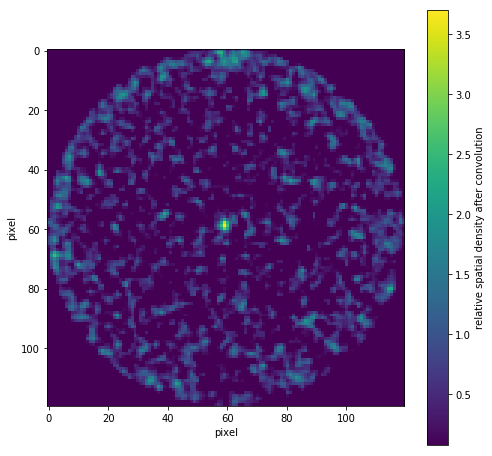

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
im = plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

# Step 3 - Run Peak Finder
Find the statistically significant peaks

In [34]:
# find peaks
small_k = 2.0
mn, med, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
tbl = find_peaks(clipped,med+3,box_size=small_k*2)

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print(tbl)

x_peak y_peak   peak_value        ra           dec      
------ ------ ------------- ------------- --------------
    59     59 3.69850998804 185.410454081 -31.9882957569


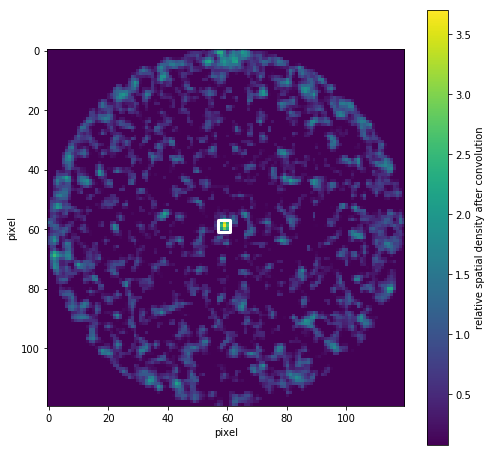

In [35]:
ecs = ['w','y'] # colors of box frames
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

# Download data to make CMD

In [38]:
# Convert X/Y to RA/DEC
tbl0 = tbl[0]
df = getBlueStarData(tbl0['ra'],tbl0['dec'],radius=0.1,classcut=0.6,fwhmcut=1.5)
print(str(len(df))+' objects found')

SELECT ra,dec,gmag,rmag FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,185.410454,-31.988296,0.100000) and class_star>0.600000 and fwhm<1.500000
Returning Pandas dataframe
1350 objects found


In [39]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)